In [1]:
import sys
sys.path.append("..")

# backends
from qiskit.providers.fake_provider import Fake27QPulseV1,Fake5QV1,Fake20QV1


# poly_sabre
from isl_sabre.poly_circuit_preprocess import *
from isl_sabre.poly_circuit_utils import *
from isl_sabre.poly_sabre import POLY_SABRE


# original sabre
from original_sabre.sabre import run_sabre

In [2]:
edges = Fake27QPulseV1().configuration().coupling_map

In [3]:
"""
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance="ibm-q/open/main")
 
backend = service.backend("ibm_sherbrooke")


backend_name = backend.name
edges = backend.configuration().coupling_map
"""

'\nfrom qiskit_ibm_runtime import QiskitRuntimeService\n\nservice = QiskitRuntimeService(instance="ibm-q/open/main")\n \nbackend = service.backend("ibm_sherbrooke")\n\n\nbackend_name = backend.name\nedges = backend.configuration().coupling_map\n'

In [4]:
file_path = "../benchmarks/polyhedral/queko-bss-16qbt/16QBT_500CYC_QSE_0.json"
data = json_file_to_isl(file_path)


In [5]:
single_trial_swap_count, multi_trial_swap_count = run_sabre(data, edges)  
print("Swap count for single trial:", single_trial_swap_count)  
print("Swap count for multi trial:", multi_trial_swap_count)  

Swap count for single trial: 662
Swap count for multi trial: 561


In [6]:
data = json_file_to_isl(file_path)
poly_sabre = POLY_SABRE(edges,data)

In [7]:
start_time = time.time()
swap_count = poly_sabre.run(heuristic_method="decay",verbose=1)
total_time = time.time()-start_time

Executing Gates: 100%|██████████| 1600/1600 [03:17<00:00,  8.08it/s]


In [8]:
print("Poly swap count for single trial :",swap_count)

Poly swap count for single trial : 571


In [9]:
for name, elapsed in poly_sabre.instruction_times.items():
    print(f"{name}: {elapsed:.6f} seconds")

extract_gate_time: 29.985075 seconds
remove_execute_gate_time: 19.894266 seconds
waiting_nodes_time: 21.116000 seconds
front_layer_gates_time: 0.052185 seconds
find_best_node_time: 0.003248 seconds
Extended_layer: 56.744588 seconds
combined_domain: 0.160810 seconds
mapping: 0.167558 seconds
simplified_access: 33.032874 seconds
new_access: 1.945993 seconds
logical_qubits: 4.880331 seconds
physical_qubits: 0.065936 seconds
physical_qubits_int: 0.084955 seconds
swap_candidate_list: 0.569026 seconds
heuristic_time: 124.742184 seconds


-------------------------

Running PolySabre: 100%|██████████| 100/100 [04:46<00:00,  2.86s/chunk]


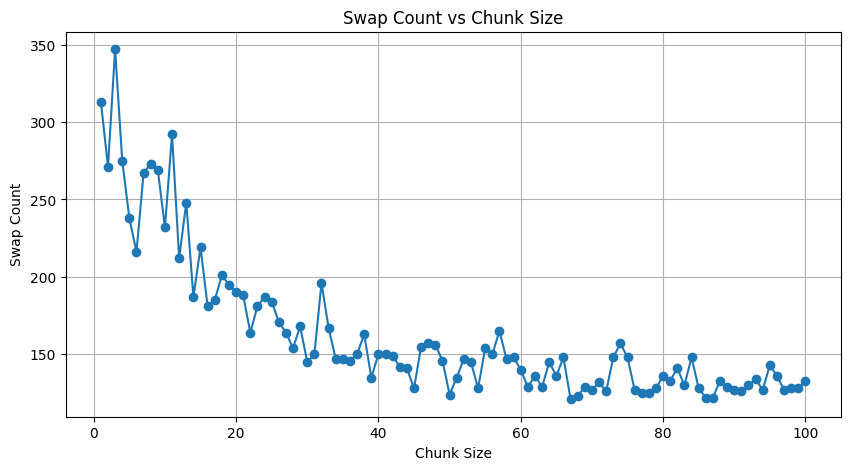

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm


chunk_sizes = list(range(1, 101))
swap_counts = []

for chunk_size in tqdm(chunk_sizes, desc="Running PolySabre", unit="chunk"):
    swap_count = poly_sabre.run(heuristic_method="decay", chunk_size=chunk_size)
    swap_counts.append(swap_count)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(chunk_sizes, swap_counts, marker='o', linestyle='-')
plt.xlabel("Chunk Size")
plt.ylabel("Swap Count")
plt.title("Swap Count vs Chunk Size")
plt.grid(True)
plt.show()

--------------

In [19]:
import re
from collections import defaultdict
from itertools import product

def parse_mapping(s):
    """
    Parse a string representing a DAG into a dictionary where keys are integers
    and values are lists of integers based on expressions and conditions.

    Args:
        s (str): Input string, e.g., "{ [5] -> q[i+j] : 1 <= i <= 3 and 2 <= j <= 4 }"
                 or "{ q[-184 + i0] : 188 <= i0 <= 195 and (i0 >= 194 or i0 <= 189) }"

    Returns:
        dict: Dictionary with integer keys and lists of integer values.
    """
    # Remove curly braces and split into entries
    s = s.strip('{}').strip()
    entries = s.split(';')
    dag = defaultdict(list)

    for entry in entries:
        entry = entry.strip()
        if not entry:
            continue

        # Determine if it's the existing format or new format
        if '->' in entry:
            # Existing format: [key] -> q[expr] : conditions
            left, right = entry.split('->', 1)
            key_part = re.search(r'\[(.*?)\]', left)
            if not key_part:
                continue
            key_str = key_part.group(1).strip()
            if key_str.isdigit():
                key = int(key_str)
                key_var = None
            else:
                key_var = key_str
                key = None
            right = right.strip()
        else:
            # New format: q[expr] : conditions, implicit key is 'i0'
            right = entry
            key_var = 'i0'
            key = None

        # Extract expression and conditions
        if ':' in right:
            value_part, condition_part = right.split(':', 1)
            value_part = value_part.strip()
            condition_part = condition_part.strip()
        else:
            value_part = right.strip()
            condition_part = None

        expr_match = re.search(r'q\[(.*?)\]', value_part)
        if not expr_match:
            continue
        expr = expr_match.group(1).strip()
        # Add explicit multiplication, e.g., '10i0' -> '10*i0'
        expr = re.sub(r'(\d+)([a-zA-Z_]\w*)', r'\1*\2', expr)

        # Parse conditions
        var_ranges = {}
        if condition_part:
            # Add explicit multiplication in conditions
            condition_part = re.sub(r'(\d+)([a-zA-Z_]\w*)', r'\1*\2', condition_part)
            # Split conditions by 'and' to find range constraints
            condition_parts = re.split(r'\s+and\s+', condition_part)
            for part in condition_parts:
                part = part.strip()
                match = re.match(r'^\s*(.*?)\s*<=\s*([a-zA-Z0-9_]+)\s*<=\s*(.*?)\s*$', part)
                if match:
                    lower_expr = match.group(1).strip()
                    var_name = match.group(2).strip()
                    upper_expr = match.group(3).strip()
                    var_ranges[var_name] = {'lower': lower_expr, 'upper': upper_expr}

        # Process based on key type
        if key is not None:  # Fixed integer key
            if not condition_part:
                # No conditions, evaluate expression directly
                try:
                    value = eval(expr, {})
                    dag[key].append(value)
                except:
                    pass
            else:
                # Generate combinations for variables
                var_names = sorted(var_ranges.keys())
                if not var_names:
                    # Conditions exist but no range variables, evaluate condition
                    try:
                        if eval(condition_part, {}):
                            value = eval(expr, {})
                            dag[key].append(value)
                    except:
                        pass
                else:
                    # Compute ranges and generate combinations
                    var_values = {}
                    try:
                        for var in var_names:
                            lower = eval(var_ranges[var]['lower'], {})
                            upper = eval(var_ranges[var]['upper'], {})
                            var_values[var] = range(int(lower), int(upper) + 1)
                        for combo in product(*var_values.values()):
                            context = dict(zip(var_names, combo))
                            if eval(condition_part, {}, context):
                                value = eval(expr, {}, context)
                                dag[key].append(value)
                    except:
                        pass

        else:  # Variable key (key_var)
            if not condition_part or key_var not in var_ranges:
                continue
            try:
                # Determine range for key variable
                lower_key = eval(var_ranges[key_var]['lower'], {})
                upper_key = eval(var_ranges[key_var]['upper'], {})
                for key_value in range(int(lower_key), int(upper_key) + 1):
                    context = {key_var: key_value}
                    other_vars = {v: var_ranges[v] for v in var_ranges if v != key_var}
                    if not other_vars:
                        # No other variables, check full condition
                        if eval(condition_part, {}, context):
                            try:
                                value = eval(expr, {}, context)
                                dag[key_value].append(value)
                            except:
                                pass
                    else:
                        # Generate combinations for other variables
                        var_values = {}
                        for var in other_vars:
                            try:
                                lower = eval(other_vars[var]['lower'], context)
                                upper = eval(other_vars[var]['upper'], context)
                                var_values[var] = range(int(lower), int(upper) + 1)
                            except:
                                continue
                        if var_values:
                            keys = var_values.keys()
                            for combo in product(*var_values.values()):
                                full_context = context.copy()
                                full_context.update(zip(keys, combo))
                                if eval(condition_part, {}, full_context):
                                    try:
                                        value = eval(expr, {}, full_context)
                                        dag[key_value].append(value)
                                    except:
                                        pass
                        else:
                            # No valid ranges for other vars, evaluate with key only
                            if eval(condition_part, {}, context):
                                try:
                                    value = eval(expr, {}, context)
                                    dag[key_value].append(value)
                                except:
                                    pass
            except:
                pass

    return dict(dag)


In [20]:
my_dict = parse_mapping(str)

In [21]:
my_dict[193]

[3]

In [18]:
import re
from collections import defaultdict

def parse_mapping(s):

    # Remove curly braces and whitespace
    s = s.strip('{}').strip()
    entries = s.split(';')
    dag = defaultdict(list)
    
    for entry in entries:
        entry = entry.strip()
    
    # Extract components using regex
    key_match = re.search(r'\[(.*?)\]\s*->', s)  # e.g., [i0]
    expr_match = re.search(r'q\[(.*?)\]', s)     # e.g., q[-184 + i0]
    condition_match = re.search(r':\s*(.*)', s)  # e.g., 188 <= i0 <= 195 and ...
    
    # Return empty dict if parsing fails
    if not key_match or not expr_match or not condition_match:
        return {}
    
    key_var = key_match.group(1).strip()         # Variable name, e.g., i0
    expr = expr_match.group(1).strip()           # Expression, e.g., -184 + i0
    condition = condition_match.group(1).strip() # Condition string
    
    # Add explicit multiplication for terms like '10i0' -> '10*i0'
    expr = re.sub(r'(\d+)([a-zA-Z_]\w*)', r'\1*\2', expr)
    condition = re.sub(r'(\d+)([a-zA-Z_]\w*)', r'\1*\2', condition)
    
    # Extract range from condition, e.g., 188 <= i0 <= 195
    range_match = re.search(r'(\d+)\s*<=\s*' + re.escape(key_var) + r'\s*<=\s*(\d+)', condition)
    if not range_match:
        return {}
    
    lower = int(range_match.group(1))  # Lower bound, e.g., 188
    upper = int(range_match.group(2))  # Upper bound, e.g., 195
    
    # Initialize result dictionary
    dag = defaultdict(list)
    
    # Evaluate for each value in the range
    for i0 in range(lower, upper + 1):
        context = {key_var: i0}  # Define i0 for eval
        try:
            # Check if condition is satisfied
            if eval(condition, {}, context):
                # Compute the value from the expression
                value = eval(expr, {}, context)
                dag[i0].append(value)
        except Exception:
            continue  # Skip if evaluation fails
    
    return dict(dag)

# Example usage
if __name__ == "__main__":
    s = "{ [i0] -> q[-184 + i0] : 188 <= i0 <= 195 and (i0 >= 194 or i0 <= 189) }"
    result = parse_mapping(s)
    print(result)

{188: [4], 189: [5], 194: [10], 195: [11]}


In [41]:
my_dict[193]

[9, 3]

In [22]:
real_dict_str = "{1361: [0, 1], 1362: [10, 11], 2149: [15], 2150: [2], 2269: [14, 13], 2270: [2, 5], 2094: [15, 0], 2095: [5, 2], 1560: [15], 1561: [4], 2069: [12], 2070: [4], 1996: [12], 1997: [4], 1904: [13, 0], 1905: [5, 2], 1195: [13], 1196: [1], 1924: [10, 12], 1925: [3, 7], 1585: [12], 1586: [4], 1805: [8], 1806: [1], 1241: [10, 11], 1242: [0, 15], 2014: [15, 0], 2015: [9, 3], 1484: [15, 2], 1485: [7, 3], 1913: [8, 5], 1914: [2, 15], 1117: [12, 4], 1118: [2, 15], 996: [15, 0], 997: [5, 2], 1600: [12, 10], 1601: [6, 14], 859: [15, 2], 860: [4, 12], 1178: [9], 1179: [1], 843: [15], 844: [4], 645: [15], 646: [1], 1495: [13, 2], 1496: [7, 3], 1429: [10, 11], 1430: [4, 12], 2142: [8, 11], 2143: [4, 12], 1397: [10, 11], 1398: [4, 15], 2060: [15, 4], 2061: [11, 8], 804: [12, 4], 805: [2, 13], 1930: [7], 1931: [3], 1531: [8, 5], 1532: [3, 7], 1834: [8, 11], 1835: [4, 15], 1042: [12, 10], 1043: [5, 8], 912: [10], 913: [2], 1401: [9, 6], 1402: [4, 12], 1731: [14], 1732: [10], 2207: [5], 2208: [2], 1611: [5, 2], 1612: [1, 7], 618: [10, 11], 619: [0, 13], 1934: [13, 0], 1935: [10, 12], 1902: [10], 1903: [7], 1141: [9, 6], 1142: [4, 12], 1381: [7], 1382: [3], 497: [15], 498: [4], 900: [13], 901: [7], 487: [12], 488: [1], 1777: [8], 1778: [5], 2153: [7, 3], 2154: [5, 8], 608: [9, 6], 609: [2, 5], 505: [14], 506: [6], 1170: [11], 1171: [8], 582: [7, 3], 583: [1, 0], 767: [9], 768: [6], 320: [12], 321: [5], 746: [7, 3], 747: [4, 15], 2145: [1], 2146: [0], 2107: [12, 4], 2108: [11, 8], 1891: [13, 14], 1880: [0, 1], 624: [4], 625: [1], 774: [13], 775: [11], 1376: [11], 1377: [10], 337: [4, 12], 338: [0, 13], 188: [15, 4], 189: [8, 5], 1327: [10, 11], 1316: [0, 1], 1243: [5, 8], 1244: [4, 12], 191: [7], 192: [1], 1097: [0, 1], 1066: [13, 14], 525: [15, 4], 526: [13, 14], 950: [13, 14], 937: [0, 1], 853: [1], 854: [0], 770: [13, 14], 758: [10, 11], 104: [7, 1], 105: [0, 13], 705: [2], 706: [1], 424: [13, 14], 420: [0, 1], 46: [9], 47: [3], 129: [15, 4], 130: [13, 14], 197: [5], 198: [4], 96: [6], 97: [4], 18: [10, 11], 19: [0, 13], 83: [11, 8], 84: [10, 12], 35: [11], 36: [10], 3: [5], 4: [3], 5: [1], 184: [10], 185: [11], 181: [0], 182: [1], 194: [10], 195: [11], 203: [11], 204: [12], 87: [8], 88: [12], 269: [12, 10], 270: [14, 13], 278: [12], 279: [14], 101: [3], 102: [9], 398: [7, 3], 399: [9, 6], 1201: [3], 1202: [4], 402: [1, 0], 403: [4, 15], 1253: [9, 6], 1254: [10, 11], 703: [13], 704: [15], 1710: [0], 1711: [1], 396: [8], 397: [14], 1231: [9, 3], 1232: [11, 10], 649: [10], 650: [14], 243: [4], 244: [15], 892: [0, 1], 893: [3, 7], 1576: [9, 3], 1577: [11, 10], 1129: [9, 6], 1130: [12, 10], 1132: [2], 1133: [5], 707: [7, 3], 708: [12, 10], 474: [6], 475: [14], 1265: [9, 6], 1266: [12, 10], 2008: [12], 2009: [14], 1403: [8, 5], 1404: [11, 10], 1506: [1], 1507: [4], 1767: [5], 1768: [8], 668: [6], 669: [14], 1105: [1], 1106: [6], 1386: [9], 1387: [13], 1390: [3], 1391: [7], 1437: [9, 3], 1438: [13, 14], 673: [4], 674: [13], 1226: [0], 1227: [5], 409: [0], 410: [15], 889: [4], 890: [11], 568: [4], 569: [15], 788: [6], 789: [14], 1461: [6], 1462: [11], 909: [5], 910: [14], 1379: [8], 1380: [14], 1204: [0], 1205: [7], 1787: [3], 1788: [9], 1357: [4], 1358: [13], 2057: [3], 2058: [9], 2241: [3], 2242: [9], 1044: [0], 1045: [13], 2064: [6], 2065: [14], 2264: [1], 2265: [11], 1875: [2], 1876: [15], 2267: [15, 4], 2249: [15], 2246: [15, 0], 2232: [15, 4], 2222: [15, 4], 2209: [15, 4], 2200: [15, 0], 2188: [15, 2], 2173: [15], 2156: [15], 2144: [15, 2], 2120: [15, 2], 2102: [15], 2087: [15, 2], 2074: [15, 0], 2044: [15], 2033: [15], 2026: [15], 2004: [15, 2], 1981: [15], 1966: [15, 0], 1938: [15], 1929: [15], 1919: [15], 1894: [15], 1883: [15], 1870: [15, 2], 1849: [15], 1847: [15, 2], 1817: [15], 1801: [15], 1797: [15, 0], 1785: [15, 2], 1774: [15, 0], 1761: [15], 1749: [15, 2], 1737: [15, 2], 1722: [15], 1712: [15], 1701: [15], 1690: [15, 0], 1681: [15], 1671: [15, 0], 1652: [15], 1649: [15, 4], 1636: [15, 2], 1625: [15, 2], 1604: [15], 1599: [15, 4], 1583: [15], 1575: [15], 1557: [15, 4], 1530: [15, 4], 1505: [15], 1497: [15, 0], 1466: [15], 1455: [15], 1436: [15, 4], 1428: [15, 0], 1417: [15, 0], 1383: [15], 1366: [15], 1348: [15], 1336: [15], 1326: [15, 0], 1314: [15], 1301: [15], 1291: [15, 2], 1278: [15], 1267: [15, 0], 1246: [15], 1225: [15], 1218: [15], 1208: [15], 1197: [15, 2], 1187: [15, 0], 1175: [15, 0], 1164: [15, 2], 1147: [15], 1143: [15, 0], 1125: [15], 1107: [15, 0], 1088: [15, 4], 1079: [15, 4], 1059: [15], 1053: [15], 1037: [15], 1021: [15], 1018: [15, 2], 1008: [15, 0], 985: [15, 2], 957: [15], 952: [15, 2], 931: [15], 920: [15], 914: [15, 0], 885: [15], 878: [15], 871: [15, 2], 838: [15, 4], 824: [15, 2], 800: [15], 792: [15, 2], 783: [15, 0], 764: [15], 739: [15, 0], 725: [15], 721: [15, 2], 699: [15, 4], 667: [15, 0], 637: [15], 623: [15], 596: [15], 581: [15], 561: [15, 4], 538: [15, 2], 508: [15], 491: [15, 4], 472: [15], 470: [15, 4], 452: [15], 447: [15, 2], 434: [15, 4], 418: [15], 392: [15, 0], 381: [15, 0], 370: [15, 2], 352: [15], 343: [15], 339: [15, 2], 328: [15, 4], 311: [15], 297: [15], 290: [15], 277: [15], 264: [15], 254: [15], 235: [15, 4], 225: [15, 0], 207: [15], 200: [15, 0], 161: [15], 147: [15], 142: [15, 0], 116: [15], 98: [15], 91: [15, 4], 85: [15, 0], 75: [15, 2], 64: [15, 0], 45: [15], 41: [15, 0], 26: [15], 16: [15], 9: [15, 2], 2252: [14], 2248: [14, 13], 2235: [14, 13], 2215: [14], 2210: [14, 6], 2197: [14], 2189: [14, 6], 2175: [14, 6], 2161: [14], 2151: [14], 2137: [14], 2124: [14], 2096: [14, 6], 2088: [14, 13], 2063: [14, 6], 2042: [14], 2034: [14], 2018: [14], 1987: [14], 1979: [14, 6], 1969: [14, 13], 1948: [14], 1943: [14, 6], 1933: [14, 6], 1926: [14, 13], 1911: [14, 13], 1896: [14], 1882: [14, 13], 1863: [14], 1857: [14], 1831: [14], 1813: [14], 1804: [14], 1786: [14, 6], 1769: [14], 1752: [14], 1747: [14, 6], 1727: [14, 13], 1715: [14, 13], 1704: [14, 13], 1691: [14, 13], 1663: [14], 1650: [14], 1639: [14], 1631: [14], 1623: [14], 1609: [14, 6], 1591: [14, 6], 1578: [14, 13], 1559: [14], 1555: [14], 1535: [14], 1525: [14], 1521: [14, 13], 1510: [14, 13], 1489: [14], 1482: [14], 1464: [14], 1426: [14], 1414: [14], 1405: [14, 13], 1396: [14], 1373: [14, 13], 1363: [14, 6], 1343: [14], 1334: [14], 1321: [14], 1308: [14], 1293: [14], 1280: [14, 6], 1256: [14], 1252: [14], 1240: [14, 6], 1230: [14], 1216: [14], 1203: [14], 1198: [14, 6], 1186: [14, 13], 1177: [14, 13], 1166: [14, 13], 1150: [14], 1135: [14], 1127: [14], 1115: [14], 1110: [14, 13], 1093: [14], 1083: [14], 1073: [14], 1055: [14, 6], 1036: [14], 1030: [14, 6], 1005: [14], 990: [14], 983: [14], 968: [14], 938: [14, 6], 919: [14], 896: [14], 880: [14], 865: [14], 858: [14, 6], 840: [14], 836: [14, 6], 825: [14, 6], 814: [14, 6], 801: [14], 782: [14, 6], 755: [14], 738: [14, 13], 724: [14], 717: [14], 709: [14, 6], 691: [14], 666: [14, 6], 642: [14, 13], 631: [14, 13], 620: [14, 6], 601: [14], 593: [14], 578: [14], 572: [14], 562: [14, 6], 549: [14], 529: [14], 501: [14, 6], 492: [14, 6], 471: [14, 6], 451: [14], 442: [14], 430: [14], 415: [14, 6], 384: [14], 379: [14], 367: [14], 353: [14], 347: [14, 6], 340: [14, 6], 319: [14], 309: [14], 291: [14], 255: [14], 248: [14, 6], 228: [14], 212: [14, 13], 199: [14], 186: [14], 152: [14], 140: [14, 6], 117: [14], 99: [14], 93: [14, 13], 80: [14], 65: [14], 58: [14], 48: [14, 6], 34: [14], 12: [14], 1: [14], 2260: [13, 2], 2219: [13], 2203: [13], 2193: [13], 2181: [13], 2176: [13, 2], 2157: [13], 2148: [13], 2136: [13], 2128: [13], 2118: [13], 2104: [13], 2089: [13], 2072: [13], 2062: [13, 2], 2050: [13, 0], 2036: [13], 2023: [13], 2005: [13], 1994: [13], 1985: [13], 1970: [13], 1958: [13, 0], 1940: [13], 1869: [13], 1845: [13], 1827: [13], 1821: [13, 0], 1809: [13, 2], 1792: [13], 1781: [13], 1760: [13], 1736: [13, 0], 1684: [13, 2], 1670: [13, 2], 1659: [13, 2], 1642: [13], 1632: [13], 1615: [13], 1610: [13, 0], 1595: [13], 1569: [13, 2], 1553: [13], 1543: [13, 2], 1473: [13], 1468: [13], 1460: [13, 0], 1445: [13], 1422: [13], 1416: [13, 2], 1347: [13], 1329: [13], 1322: [13], 1315: [13, 2], 1295: [13], 1282: [13], 1268: [13], 1257: [13], 1238: [13], 1233: [13, 2], 1215: [13], 1207: [13], 1155: [13, 0], 1138: [13], 1124: [13], 1112: [13], 1095: [13], 1078: [13], 1041: [13, 0], 1024: [13], 1015: [13], 987: [13], 973: [13, 0], 956: [13], 934: [13], 923: [13], 907: [13], 887: [13], 883: [13, 2], 863: [13], 856: [13], 839: [13], 828: [13], 818: [13], 812: [13, 0], 793: [13, 0], 759: [13, 2], 742: [13], 730: [13, 0], 716: [13], 695: [13], 686: [13, 2], 658: [13], 653: [13, 2], 603: [13], 586: [13], 585: [13, 2], 574: [13, 2], 546: [13], 534: [13], 514: [13, 0], 499: [13, 2], 478: [13, 0], 469: [13, 2], 459: [13, 2], 438: [13], 435: [13, 2], 411: [13], 394: [13], 389: [13], 377: [13], 365: [13], 350: [13], 349: [13, 2], 329: [13, 0], 288: [13], 281: [13, 2], 256: [13], 238: [13], 236: [13, 0], 216: [13], 201: [13, 2], 183: [13], 165: [13, 0], 154: [13, 2], 134: [13], 111: [13], 66: [13], 57: [13], 49: [13, 2], 27: [13], 7: [13, 0], 2268: [12, 10], 2254: [12], 2238: [12], 2225: [12], 2224: [12, 10], 2190: [12], 2185: [12], 2174: [12, 4], 2163: [12], 2130: [12], 2111: [12], 2084: [12], 2054: [12], 2047: [12], 2039: [12, 4], 2022: [12], 1990: [12, 4], 1964: [12], 1957: [12], 1945: [12, 10], 1915: [12, 10], 1900: [12], 1888: [12, 4], 1877: [12, 4], 1866: [12], 1860: [12, 4], 1839: [12], 1826: [12], 1822: [12, 4], 1802: [12], 1789: [12], 1784: [12, 4], 1775: [12, 10], 1763: [12, 10], 1746: [12, 4], 1730: [12], 1723: [12], 1707: [12], 1703: [12, 10], 1693: [12, 10], 1672: [12, 4], 1658: [12, 4], 1643: [12], 1638: [12, 4], 1622: [12], 1606: [12], 1570: [12, 10], 1547: [12], 1541: [12], 1529: [12, 10], 1517: [12], 1501: [12], 1490: [12], 1481: [12], 1467: [12], 1458: [12], 1442: [12], 1435: [12], 1407: [12], 1389: [12], 1372: [12, 4], 1352: [12, 10], 1333: [12], 1318: [12], 1317: [12, 10], 1305: [12, 10], 1287: [12], 1269: [12], 1251: [12], 1234: [12, 4], 1220: [12, 4], 1210: [12], 1188: [12, 10], 1173: [12, 10], 1167: [12, 4], 1148: [12], 1109: [12, 10], 1098: [12, 10], 1086: [12, 10], 1070: [12], 1065: [12, 4], 1052: [12], 1031: [12, 4], 1020: [12, 10], 1002: [12], 995: [12, 10], 982: [12], 969: [12], 951: [12, 10], 928: [12], 925: [12, 4], 916: [12, 4], 902: [12, 4], 888: [12], 882: [12, 4], 868: [12], 829: [12], 823: [12], 791: [12], 781: [12, 10], 769: [12, 10], 756: [12], 748: [12, 10], 740: [12, 10], 726: [12], 718: [12, 4], 698: [12, 10], 688: [12, 10], 671: [12], 657: [12], 630: [12, 10], 616: [12], 591: [12], 575: [12], 571: [12], 560: [12], 551: [12, 4], 528: [12], 494: [12], 481: [12, 10], 443: [12], 433: [12, 10], 422: [12, 4], 414: [12, 10], 395: [12], 382: [12, 4], 371: [12, 10], 360: [12, 10], 346: [12, 10], 317: [12, 4], 258: [12, 4], 246: [12], 237: [12, 10], 215: [12], 178: [12], 159: [12], 153: [12, 10], 132: [12], 123: [12], 113: [12], 100: [12], 74: [12, 4], 54: [12], 33: [12], 21: [12], 13: [12], 2253: [11], 2243: [11], 2229: [11], 2216: [11], 2211: [11, 8], 2201: [11, 10], 2186: [11], 2172: [11], 2158: [11], 2152: [11, 10], 2131: [11, 8], 2115: [11], 2091: [11], 2078: [11], 2075: [11, 8], 2051: [11, 10], 2030: [11], 2016: [11], 2007: [11], 2001: [11], 1984: [11], 1980: [11, 8], 1967: [11, 8], 1952: [11], 1941: [11], 1917: [11], 1909: [11], 1899: [11], 1889: [11, 8], 1878: [11, 10], 1872: [11, 10], 1853: [11], 1840: [11], 1811: [11], 1808: [11, 10], 1790: [11], 1780: [11], 1772: [11], 1751: [11], 1748: [11, 10], 1735: [11, 8], 1709: [11], 1705: [11, 8], 1685: [11], 1674: [11], 1669: [11], 1660: [11, 10], 1648: [11, 10], 1626: [11, 8], 1602: [11], 1593: [11], 1588: [11], 1562: [11], 1544: [11, 8], 1508: [11], 1491: [11], 1480: [11], 1453: [11], 1446: [11, 10], 1439: [11, 10], 1412: [11], 1374: [11, 8], 1346: [11], 1330: [11], 1313: [11], 1303: [11], 1284: [11], 1273: [11], 1264: [11], 1222: [11, 10], 1199: [11, 8], 1184: [11], 1158: [11], 1154: [11, 8], 1137: [11], 1128: [11], 1120: [11, 8], 1101: [11], 1096: [11, 8], 1081: [11], 1080: [11, 10], 1060: [11], 1046: [11], 1035: [11], 1022: [11], 1012: [11], 1006: [11], 992: [11], 984: [11, 10], 974: [11, 10], 960: [11], 941: [11], 939: [11, 8], 926: [11, 10], 904: [11, 8], 877: [11], 864: [11], 847: [11], 834: [11], 817: [11], 807: [11], 795: [11, 10], 749: [11, 8], 733: [11], 714: [11], 701: [11], 693: [11], 682: [11], 670: [11], 664: [11], 652: [11], 641: [11, 8], 598: [11], 584: [11, 10], 573: [11, 10], 558: [11], 548: [11], 539: [11, 10], 522: [11], 512: [11, 10], 502: [11, 10], 490: [11, 8], 480: [11, 8], 468: [11], 437: [11], 423: [11, 8], 405: [11], 401: [11, 10], 391: [11, 10], 380: [11, 10], 366: [11], 357: [11], 341: [11], 330: [11], 327: [11, 10], 314: [11], 303: [11], 275: [11], 268: [11, 8], 247: [11], 230: [11], 218: [11], 173: [11], 166: [11, 10], 143: [11, 10], 128: [11, 10], 112: [11], 106: [11, 10], 92: [11, 10], 67: [11], 63: [11, 10], 29: [11, 8], 8: [11, 10], 2256: [10], 2245: [10], 2205: [10], 2182: [10], 2169: [10], 2160: [10], 2138: [10], 2122: [10], 2110: [10], 2100: [10], 2092: [10], 2077: [10], 2067: [10], 2053: [10], 2031: [10], 2006: [10], 2000: [10], 1983: [10], 1973: [10], 1960: [10], 1949: [10], 1886: [10], 1848: [10], 1841: [10], 1823: [10], 1814: [10], 1795: [10], 1776: [10], 1717: [10], 1713: [10], 1678: [10], 1662: [10], 1635: [10], 1619: [10], 1603: [10], 1549: [10], 1537: [10], 1520: [10], 1486: [10], 1474: [10], 1469: [10], 1451: [10], 1370: [10], 1332: [10], 1283: [10], 1271: [10], 1212: [10], 1190: [10], 1159: [10], 1145: [10], 1057: [10], 1051: [10], 1023: [10], 1003: [10], 962: [10], 897: [10], 891: [10], 879: [10], 866: [10], 855: [10], 845: [10], 827: [10], 822: [10], 810: [10], 799: [10], 722: [10], 713: [10], 672: [10], 659: [10], 604: [10], 592: [10], 554: [10], 541: [10], 521: [10], 484: [10], 466: [10], 449: [10], 439: [10], 416: [10], 332: [10], 313: [10], 302: [10], 286: [10], 273: [10], 239: [10], 219: [10], 208: [10], 171: [10], 108: [10], 68: [10], 44: [10], 23: [10], 2271: [9, 6], 2251: [9], 2234: [9, 3], 2223: [9, 3], 2206: [9], 2191: [9], 2187: [9, 3], 2178: [9, 3], 2155: [9], 2141: [9], 2125: [9], 2101: [9], 2097: [9, 3], 2083: [9], 2071: [9], 2049: [9, 3], 2038: [9, 3], 2019: [9], 2003: [9, 6], 1991: [9, 6], 1974: [9], 1962: [9], 1951: [9], 1922: [9], 1908: [9], 1895: [9], 1892: [9, 6], 1881: [9, 3], 1871: [9, 3], 1851: [9], 1828: [9], 1812: [9], 1782: [9, 3], 1764: [9], 1750: [9], 1739: [9], 1729: [9], 1716: [9], 1714: [9, 6], 1702: [9, 3], 1689: [9, 6], 1673: [9], 1661: [9], 1657: [9, 6], 1646: [9, 6], 1627: [9], 1613: [9], 1608: [9, 3], 1592: [9], 1580: [9], 1568: [9, 3], 1545: [9], 1533: [9], 1523: [9], 1511: [9], 1498: [9], 1494: [9, 6], 1483: [9, 6], 1463: [9], 1452: [9], 1448: [9, 3], 1427: [9], 1415: [9, 6], 1375: [9], 1364: [9], 1353: [9], 1341: [9], 1338: [9, 3], 1325: [9, 6], 1311: [9], 1298: [9], 1290: [9, 3], 1274: [9], 1235: [9], 1213: [9], 1200: [9], 1189: [9], 1172: [9, 6], 1163: [9], 1146: [9], 1116: [9, 3], 1104: [9], 1094: [9], 1087: [9, 6], 1077: [9], 1050: [9], 1040: [9], 1026: [9], 1017: [9, 3], 999: [9], 986: [9, 3], 975: [9, 6], 964: [9, 6], 942: [9], 936: [9], 927: [9, 3], 915: [9, 3], 903: [9, 3], 894: [9, 6], 881: [9, 3], 870: [9, 3], 852: [9], 842: [9], 831: [9], 819: [9], 811: [9, 3], 803: [9], 790: [9], 777: [9], 757: [9], 744: [9], 736: [9], 729: [9, 6], 712: [9], 697: [9, 3], 685: [9, 6], 677: [9, 3], 656: [9], 654: [9, 6], 633: [9], 626: [9], 614: [9], 590: [9], 555: [9], 550: [9, 6], 536: [9], 518: [9], 511: [9], 496: [9], 485: [9], 473: [9], 467: [9], 455: [9], 446: [9, 6], 428: [9], 419: [9], 413: [9, 3], 393: [9, 3], 374: [9], 372: [9, 3], 354: [9], 345: [9, 3], 336: [9, 3], 299: [9], 293: [9, 3], 280: [9, 6], 267: [9, 6], 257: [9, 6], 241: [9], 234: [9, 6], 223: [9], 209: [9, 6], 196: [9], 180: [9], 175: [9, 3], 163: [9], 151: [9], 141: [9, 3], 131: [9, 3], 118: [9, 6], 82: [9, 3], 73: [9, 6], 59: [9], 40: [9, 3], 28: [9, 6], 10: [9], 6: [9, 6], 2263: [8], 2255: [8], 2247: [8, 5], 2227: [8], 2214: [8], 2194: [8], 2184: [8], 2171: [8], 2164: [8], 2117: [8], 2090: [8], 2080: [8], 2045: [8], 2037: [8], 2020: [8], 2013: [8, 5], 1993: [8], 1988: [8], 1950: [8], 1944: [8, 5], 1932: [8], 1923: [8], 1897: [8], 1879: [8, 5], 1852: [8], 1836: [8], 1818: [8], 1798: [8, 5], 1762: [8, 5], 1745: [8], 1720: [8], 1692: [8, 5], 1676: [8], 1667: [8], 1656: [8], 1644: [8], 1629: [8], 1605: [8], 1598: [8, 5], 1589: [8], 1574: [8], 1558: [8], 1556: [8, 5], 1513: [8], 1503: [8], 1488: [8], 1477: [8], 1459: [8], 1443: [8], 1421: [8], 1406: [8], 1359: [8], 1344: [8], 1340: [8, 5], 1319: [8], 1310: [8], 1302: [8], 1288: [8], 1258: [8], 1247: [8], 1229: [8], 1217: [8], 1181: [8], 1161: [8], 1139: [8], 1126: [8], 1100: [8], 1082: [8], 1069: [8], 1063: [8], 1025: [8], 1016: [8], 1009: [8, 5], 993: [8], 977: [8], 966: [8], 958: [8], 946: [8], 921: [8], 908: [8], 886: [8], 873: [8], 861: [8, 5], 851: [8, 5], 830: [8], 826: [8, 5], 808: [8], 802: [8], 794: [8, 5], 778: [8], 762: [8], 753: [8], 732: [8], 731: [8, 5], 720: [8, 5], 710: [8, 5], 694: [8], 680: [8], 676: [8], 660: [8], 621: [8], 611: [8], 605: [8], 594: [8], 579: [8], 563: [8, 5], 547: [8], 535: [8], 523: [8], 507: [8], 500: [8, 5], 461: [8], 450: [8], 441: [8], 426: [8], 406: [8], 388: [8], 383: [8, 5], 356: [8], 348: [8, 5], 333: [8], 325: [8], 312: [8], 300: [8], 285: [8], 282: [8, 5], 260: [8, 5], 250: [8, 5], 229: [8], 214: [8], 211: [8, 5], 168: [8], 138: [8], 122: [8], 109: [8], 107: [8, 5], 76: [8, 5], 51: [8, 5], 39: [8], 17: [8], 0: [8], 2261: [7], 2258: [7, 3], 2239: [7], 2233: [7, 1], 2217: [7], 2212: [7, 1], 2195: [7], 2180: [7], 2177: [7, 1], 2167: [7, 3], 2134: [7], 2132: [7, 3], 2119: [7, 3], 2098: [7], 2093: [7, 1], 2086: [7, 1], 2073: [7, 3], 2052: [7], 2040: [7], 2028: [7], 2027: [7, 3], 2012: [7, 1], 1999: [7], 1986: [7], 1972: [7], 1912: [7, 3], 1887: [7, 1], 1873: [7], 1861: [7], 1858: [7, 3], 1833: [7, 3], 1815: [7], 1807: [7], 1796: [7, 1], 1779: [7], 1770: [7], 1758: [7], 1740: [7], 1738: [7, 3], 1725: [7], 1708: [7], 1697: [7], 1688: [7], 1675: [7], 1668: [7], 1655: [7], 1647: [7, 1], 1634: [7], 1616: [7], 1597: [7], 1590: [7], 1572: [7], 1567: [7], 1546: [7], 1540: [7], 1514: [7], 1499: [7], 1472: [7, 3], 1450: [7], 1441: [7], 1433: [7], 1420: [7], 1413: [7], 1371: [7], 1354: [7], 1351: [7, 3], 1328: [7, 1], 1309: [7], 1304: [7, 3], 1286: [7], 1270: [7], 1260: [7], 1250: [7], 1236: [7], 1223: [7, 3], 1191: [7], 1182: [7], 1174: [7, 3], 1162: [7], 1149: [7], 1136: [7], 1131: [7, 1], 1113: [7], 1103: [7], 1091: [7], 1084: [7, 3], 1067: [7], 1056: [7], 1054: [7, 3], 1032: [7], 1027: [7, 3], 1011: [7], 1007: [7, 3], 994: [7, 1], 978: [7], 972: [7, 1], 963: [7, 3], 948: [7], 932: [7], 922: [7], 911: [7], 876: [7], 869: [7, 1], 857: [7, 3], 850: [7, 3], 835: [7, 3], 816: [7], 798: [7], 787: [7], 780: [7, 3], 765: [7], 751: [7], 737: [7, 3], 728: [7, 3], 711: [7], 696: [7], 687: [7, 1], 679: [7, 1], 663: [7], 644: [7], 640: [7, 3], 629: [7, 3], 610: [7], 600: [7], 599: [7, 3], 564: [7], 552: [7], 540: [7], 527: [7], 524: [7, 3], 504: [7], 493: [7], 489: [7, 3], 477: [7, 1], 464: [7], 458: [7, 1], 448: [7, 3], 431: [7], 425: [7, 3], 412: [7, 1], 390: [7, 1], 373: [7], 361: [7], 359: [7, 3], 342: [7], 334: [7], 326: [7], 315: [7, 1], 306: [7, 1], 289: [7], 276: [7], 271: [7, 3], 251: [7], 249: [7, 1], 231: [7], 224: [7], 210: [7, 3], 174: [7], 160: [7], 146: [7], 139: [7], 121: [7], 119: [7, 3], 94: [7, 3], 69: [7], 60: [7], 42: [7], 31: [7], 24: [7], 2244: [6], 2228: [6], 2221: [6], 2196: [6], 2159: [6], 2147: [6], 2126: [6], 2114: [6], 2103: [6], 2076: [6], 2046: [6], 2035: [6], 2024: [6], 1963: [6], 1953: [6], 1918: [6], 1901: [6], 1874: [6], 1865: [6], 1854: [6], 1844: [6], 1824: [6], 1791: [6], 1757: [6], 1724: [6], 1695: [6], 1683: [6], 1630: [6], 1617: [6], 1565: [6], 1552: [6], 1538: [6], 1528: [6], 1519: [6], 1502: [6], 1449: [6], 1440: [6], 1431: [6], 1418: [6], 1394: [6], 1378: [6], 1365: [6], 1342: [6], 1335: [6], 1306: [6], 1292: [6], 1281: [6], 1228: [6], 1214: [6], 1211: [6], 1156: [6], 1144: [6], 1114: [6], 1075: [6], 1061: [6], 1038: [6], 1010: [6], 1000: [6], 988: [6], 979: [6], 949: [6], 918: [6], 905: [6], 899: [6], 875: [6], 862: [6], 848: [6], 735: [6], 715: [6], 635: [6], 627: [6], 595: [6], 580: [6], 565: [6], 537: [6], 520: [6], 456: [6], 417: [6], 386: [6], 378: [6], 362: [6], 324: [6], 308: [6], 305: [6], 287: [6], 213: [6], 190: [6], 177: [6], 167: [6], 155: [6], 144: [6], 120: [6], 86: [6], 77: [6], 52: [6], 30: [6], 2250: [5], 2230: [5], 2199: [5], 2170: [5], 2166: [5, 2], 2135: [5], 2113: [5], 2099: [5], 2085: [5], 2068: [5], 2056: [5], 2041: [5], 2025: [5], 1998: [5], 1992: [5, 2], 1971: [5], 1968: [5, 2], 1956: [5], 1936: [5, 2], 1927: [5, 2], 1890: [5, 2], 1867: [5], 1856: [5], 1837: [5], 1830: [5], 1820: [5], 1742: [5], 1733: [5], 1728: [5, 2], 1699: [5], 1679: [5], 1664: [5], 1654: [5], 1633: [5], 1618: [5], 1582: [5], 1571: [5], 1566: [5], 1542: [5], 1522: [5, 2], 1509: [5, 2], 1492: [5], 1479: [5], 1471: [5, 2], 1454: [5], 1447: [5, 2], 1432: [5], 1419: [5], 1409: [5], 1393: [5], 1385: [5, 2], 1369: [5], 1360: [5], 1350: [5, 2], 1323: [5], 1296: [5], 1285: [5], 1259: [5], 1249: [5], 1221: [5, 2], 1206: [5], 1193: [5], 1180: [5], 1176: [5, 2], 1157: [5], 1122: [5], 1111: [5], 1108: [5, 2], 1076: [5], 1049: [5], 1028: [5, 2], 1013: [5], 980: [5], 971: [5], 961: [5], 943: [5], 929: [5], 917: [5], 874: [5], 867: [5], 832: [5], 813: [5, 2], 773: [5], 771: [5, 2], 754: [5], 745: [5], 690: [5], 678: [5, 2], 648: [5], 638: [5], 617: [5], 589: [5], 577: [5], 533: [5], 519: [5], 513: [5, 2], 483: [5], 479: [5, 2], 463: [5], 453: [5], 440: [5], 427: [5], 421: [5, 2], 408: [5], 400: [5, 2], 368: [5], 351: [5], 335: [5], 316: [5, 2], 304: [5], 294: [5, 2], 266: [5], 232: [5], 221: [5], 176: [5, 2], 158: [5], 150: [5], 133: [5], 127: [5], 114: [5], 95: [5, 2], 79: [5], 53: [5], 37: [5], 2257: [4], 2237: [4], 2198: [4], 2183: [4], 2162: [4], 2129: [4], 2112: [4], 2081: [4], 2043: [4], 2021: [4], 2011: [4], 1976: [4], 1961: [4], 1954: [4], 1937: [4], 1920: [4], 1907: [4], 1868: [4], 1838: [4], 1800: [4], 1793: [4], 1771: [4], 1759: [4], 1718: [4], 1696: [4], 1682: [4], 1621: [4], 1607: [4], 1536: [4], 1512: [4], 1487: [4], 1475: [4], 1411: [4], 1337: [4], 1324: [4], 1312: [4], 1299: [4], 1277: [4], 1262: [4], 1194: [4], 1185: [4], 1168: [4], 1102: [4], 1090: [4], 1034: [4], 1014: [4], 1004: [4], 991: [4], 981: [4], 970: [4], 959: [4], 945: [4], 930: [4], 820: [4], 806: [4], 786: [4], 779: [4], 763: [4], 752: [4], 723: [4], 700: [4], 681: [4], 662: [4], 651: [4], 634: [4], 587: [4], 576: [4], 510: [4], 445: [4], 407: [4], 385: [4], 364: [4], 358: [4], 301: [4], 292: [4], 272: [4], 262: [4], 220: [4], 170: [4], 164: [4], 148: [4], 136: [4], 110: [4], 78: [4], 56: [4], 43: [4], 38: [4], 20: [4], 2: [4], 2262: [3], 2204: [3], 2140: [3], 2079: [3], 1995: [3], 1982: [3], 1977: [3], 1965: [3], 1947: [3], 1939: [3], 1898: [3], 1884: [3], 1810: [3], 1799: [3], 1766: [3], 1754: [3], 1744: [3], 1719: [3], 1687: [3], 1680: [3], 1665: [3], 1653: [3], 1645: [3], 1628: [3], 1624: [3], 1581: [3], 1550: [3], 1518: [3], 1504: [3], 1425: [3], 1408: [3], 1368: [3], 1356: [3], 1320: [3], 1307: [3], 1276: [3], 1263: [3], 1245: [3], 1239: [3], 1192: [3], 1183: [3], 1160: [3], 1153: [3], 1134: [3], 1099: [3], 1089: [3], 1071: [3], 989: [3], 967: [3], 947: [3], 933: [3], 815: [3], 796: [3], 784: [3], 760: [3], 750: [3], 683: [3], 655: [3], 643: [3], 613: [3], 607: [3], 570: [3], 557: [3], 544: [3], 531: [3], 509: [3], 495: [3], 476: [3], 462: [3], 457: [3], 429: [3], 318: [3], 307: [3], 295: [3], 274: [3], 253: [3], 242: [3], 227: [3], 193: [3], 187: [3], 162: [3], 70: [3], 55: [3], 22: [3], 11: [3], 2240: [2], 2226: [2], 2213: [2], 2123: [2], 2105: [2], 2048: [2], 2032: [2], 2010: [2], 1975: [2], 1955: [2], 1832: [2], 1819: [2], 1794: [2], 1773: [2], 1755: [2], 1706: [2], 1700: [2], 1640: [2], 1594: [2], 1587: [2], 1573: [2], 1548: [2], 1526: [2], 1456: [2], 1434: [2], 1424: [2], 1400: [2], 1395: [2], 1355: [2], 1331: [2], 1300: [2], 1272: [2], 1248: [2], 1151: [2], 1121: [2], 1092: [2], 1074: [2], 1062: [2], 1047: [2], 1033: [2], 1001: [2], 965: [2], 954: [2], 935: [2], 884: [2], 846: [2], 833: [2], 776: [2], 743: [2], 727: [2], 661: [2], 636: [2], 628: [2], 612: [2], 553: [2], 542: [2], 515: [2], 486: [2], 404: [2], 387: [2], 376: [2], 355: [2], 322: [2], 296: [2], 263: [2], 252: [2], 240: [2], 233: [2], 222: [2], 206: [2], 179: [2], 157: [2], 137: [2], 125: [2], 103: [2], 62: [2], 15: [2], 2259: [1, 0], 2236: [1], 2220: [1], 2192: [1], 2165: [1, 0], 2133: [1], 2121: [1], 2109: [1], 2106: [1, 0], 2066: [1], 2059: [1], 2029: [1], 2002: [1, 0], 1989: [1, 0], 1978: [1, 0], 1959: [1], 1946: [1], 1942: [1, 0], 1928: [1], 1916: [1], 1906: [1], 1893: [1], 1864: [1], 1850: [1], 1843: [1], 1829: [1], 1816: [1], 1783: [1, 0], 1765: [1], 1756: [1], 1741: [1], 1734: [1], 1726: [1], 1698: [1], 1686: [1], 1666: [1], 1637: [1, 0], 1614: [1], 1584: [1], 1579: [1, 0], 1564: [1], 1554: [1], 1539: [1], 1527: [1], 1515: [1], 1493: [1], 1476: [1], 1470: [1], 1457: [1], 1444: [1], 1423: [1], 1410: [1], 1388: [1], 1384: [1, 0], 1349: [1], 1339: [1, 0], 1297: [1], 1289: [1, 0], 1275: [1], 1261: [1], 1255: [1, 0], 1237: [1], 1224: [1], 1219: [1, 0], 1209: [1], 1169: [1], 1165: [1, 0], 1152: [1], 1140: [1], 1119: [1, 0], 1085: [1, 0], 1072: [1], 1064: [1], 1048: [1], 1039: [1], 1029: [1, 0], 1019: [1, 0], 998: [1], 976: [1], 953: [1], 940: [1], 924: [1, 0], 906: [1], 898: [1], 872: [1], 841: [1], 837: [1, 0], 821: [1], 809: [1], 797: [1], 785: [1], 772: [1], 766: [1], 734: [1], 719: [1, 0], 692: [1], 665: [1], 632: [1], 615: [1], 606: [1], 597: [1], 566: [1], 556: [1], 543: [1], 530: [1], 516: [1], 503: [1, 0], 460: [1], 436: [1], 432: [1, 0], 375: [1], 369: [1], 344: [1], 331: [1], 323: [1], 284: [1], 283: [1, 0], 265: [1], 259: [1, 0], 226: [1], 217: [1], 205: [1], 169: [1], 156: [1], 145: [1], 135: [1], 124: [1], 115: [1], 89: [1], 81: [1], 71: [1], 61: [1], 50: [1, 0], 32: [1], 14: [1], 2266: [0], 2231: [0], 2218: [0], 2202: [0], 2179: [0], 2168: [0], 2139: [0], 2127: [0], 2116: [0], 2082: [0], 2055: [0], 2017: [0], 1921: [0], 1910: [0], 1885: [0], 1862: [0], 1855: [0], 1842: [0], 1825: [0], 1803: [0], 1753: [0], 1743: [0], 1721: [0], 1694: [0], 1677: [0], 1651: [0], 1641: [0], 1620: [0], 1596: [0], 1563: [0], 1551: [0], 1534: [0], 1524: [0], 1516: [0], 1500: [0], 1478: [0], 1465: [0], 1399: [0], 1392: [0], 1367: [0], 1345: [0], 1294: [0], 1279: [0], 1123: [0], 1068: [0], 1058: [0], 955: [0], 944: [0], 895: [0], 849: [0], 761: [0], 741: [0], 702: [0], 689: [0], 684: [0], 675: [0], 647: [0], 639: [0], 622: [0], 602: [0], 588: [0], 567: [0], 559: [0], 545: [0], 532: [0], 517: [0], 482: [0], 465: [0], 454: [0], 444: [0], 363: [0], 310: [0], 298: [0], 261: [0], 245: [0], 202: [0], 172: [0], 149: [0], 126: [0], 90: [0], 72: [0], 25: [0], 1859: [13, 2], 1846: [7, 3]}"

In [23]:
s = "[i0] -> q[1153 - 6i0] : 191 <= i0 <= 192"
result = parse_mapping(s)
print(result)

{191: [7], 192: [1]}


In [24]:
real_dict = eval(real_dict_str)

In [25]:
real_dict[1362]

[10, 11]

In [26]:
def dicts_equal_ignore_order(d1, d2):
    if sorted(d1.keys()) != sorted(d2.keys()):
        missing_in_d2 = set(d1.keys()) - set(d2.keys())
        missing_in_d1 = set(d2.keys()) - set(d1.keys())

        print("Keys in d1 but not in d2:", missing_in_d2)
        print("Keys in d2 but not in d1:", missing_in_d1)

        return False
    for key in set(d1.keys()) & set(d2.keys()):
        if sorted(d1[key]) != sorted(d2[key]):
            print("Key:", key, "d1 value:", d1[key], "d2 value:", d2[key])

    return True

dicts_equal_ignore_order(real_dict,my_dict)

True